# Position Snapshots Analysis

Visualize intraday position performance to analyze optimal exit timing.

In [45]:
# ============ CONFIG ============
LAST_N_DAYS = 1  # Only show trades from last N calendar days (set to None to show all)
# ================================

In [46]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import pytz

DB_PATH = '../data/earnings_trades.db'
ET = pytz.timezone('America/New_York')

# Load snapshots
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql_query("SELECT * FROM price_snapshots ORDER BY ts", conn)

# Load trades to get entry times and premium paid
trades = pd.read_sql_query("""
    SELECT trade_id, entry_datetime, earnings_date, premium_paid, contracts
    FROM trades
""", conn)
conn.close()

print(f"Loaded {len(df)} snapshots for {df['trade_id'].nunique()} trades (all time)")
df.head()

Loaded 808 snapshots for 11 trades (all time)


,id,trade_id,ts,minutes_since_open,straddle_mid,call_mid,put_mid,spot_price,unrealized_pnl,unrealized_pnl_pct,created_at
0,269,CNXC_2026-01-13_20260112191617,2026-01-13T09:30:00.007690-05:00,0,3.375,None,None,38.14,-742.5,-0.423077,2026-01-13 14:30:02
1,270,JPM_2026-01-13_20260112191613,2026-01-13T09:30:00.007690-05:00,0,8.485,None,None,324.94,-334.5,-0.282756,2026-01-13 14:30:08
2,271,CNXC_2026-01-13_20260112191617,2026-01-13T09:35:00.006695-05:00,5,3.400,None,None,41.30,-735.0,-0.418803,2026-01-13 14:35:01
3,272,DAL_2026-01-13_20260112191616,2026-01-13T09:35:00.006695-05:00,5,3.025,None,None,70.71,-690.0,-0.363158,2026-01-13 14:35:02
4,273,BK_2026-01-13_20260112191614,2026-01-13T09:35:00.006695-05:00,5,2.800,None,None,120.61,-545.0,-0.327327,2026-01-13 14:35:04


In [47]:
# Extract ticker from trade_id
df['ticker'] = df['trade_id'].str.split('_').str[0]
df['date'] = df['trade_id'].str.split('_').str[1]

# Convert to datetime (use ISO8601 format to handle timezone offsets)
df['ts'] = pd.to_datetime(df['ts'], format='ISO8601', utc=True)
trades['entry_datetime'] = pd.to_datetime(trades['entry_datetime'], format='ISO8601', utc=True)

# Merge to get entry time and premium for each snapshot
df = df.merge(trades[['trade_id', 'entry_datetime', 'premium_paid', 'contracts']], on='trade_id', how='left')

# Calculate entry price per contract (for % change calculation)
df['entry_price_per_contract'] = df['premium_paid'] / df['contracts'] / 100  # premium_paid is total $, straddle_mid is per share

# Filter to T+1 snapshots only (the exit day)
df['entry_date'] = df['entry_datetime'].dt.tz_convert(ET).dt.date
df['snap_date'] = df['ts'].dt.tz_convert(ET).dt.date

# Keep only snapshots where snap_date is exactly 1 day after entry_date
n_before = len(df)
df = df[df['snap_date'] > df['entry_date']]  # After entry day
days_held = (pd.to_datetime(df['snap_date']) - pd.to_datetime(df['entry_date'])).dt.days
df = df[days_held == 1]  # Exactly T+1
n_after = len(df)

# Use minutes_since_open directly (already minutes from 9:30 ET on T+1)
df['exit_day_min'] = df['minutes_since_open']

print(f"T+1 snapshots: {len(df)} (filtered {n_before - n_after} same-day/multi-day)")
print(f"Unique trades: {df['trade_id'].nunique()}")

T+1 snapshots: 352 (filtered 456 same-day/multi-day)
Unique trades: 6


In [48]:
# Apply date filter if configured
if LAST_N_DAYS is not None:
    cutoff_date = (datetime.now(ET) - timedelta(days=LAST_N_DAYS)).date()
    df_filtered = df[df['snap_date'] >= cutoff_date]
    n_filtered_trades = df_filtered['trade_id'].nunique()
    n_total_trades = df['trade_id'].nunique()
    print(f"Filtered to last {LAST_N_DAYS} days: {n_filtered_trades} trades (of {n_total_trades} total)")
    df = df_filtered
else:
    print("Showing all trades (no date filter)")

# Get unique exit dates for grouping
exit_dates = sorted(df['snap_date'].unique())
print(f"\nExit days in dataset: {len(exit_dates)}")
for d in exit_dates:
    day_trades = df[df['snap_date'] == d]['ticker'].unique()
    print(f"  {d}: {', '.join(day_trades)}")

Filtered to last 1 days: 6 trades (of 6 total)

Exit days in dataset: 2
  2026-01-14: BAC, C, WFC
  2026-01-15: TSM, BLK, MS


---
## P&L by Exit Day (Subplots)

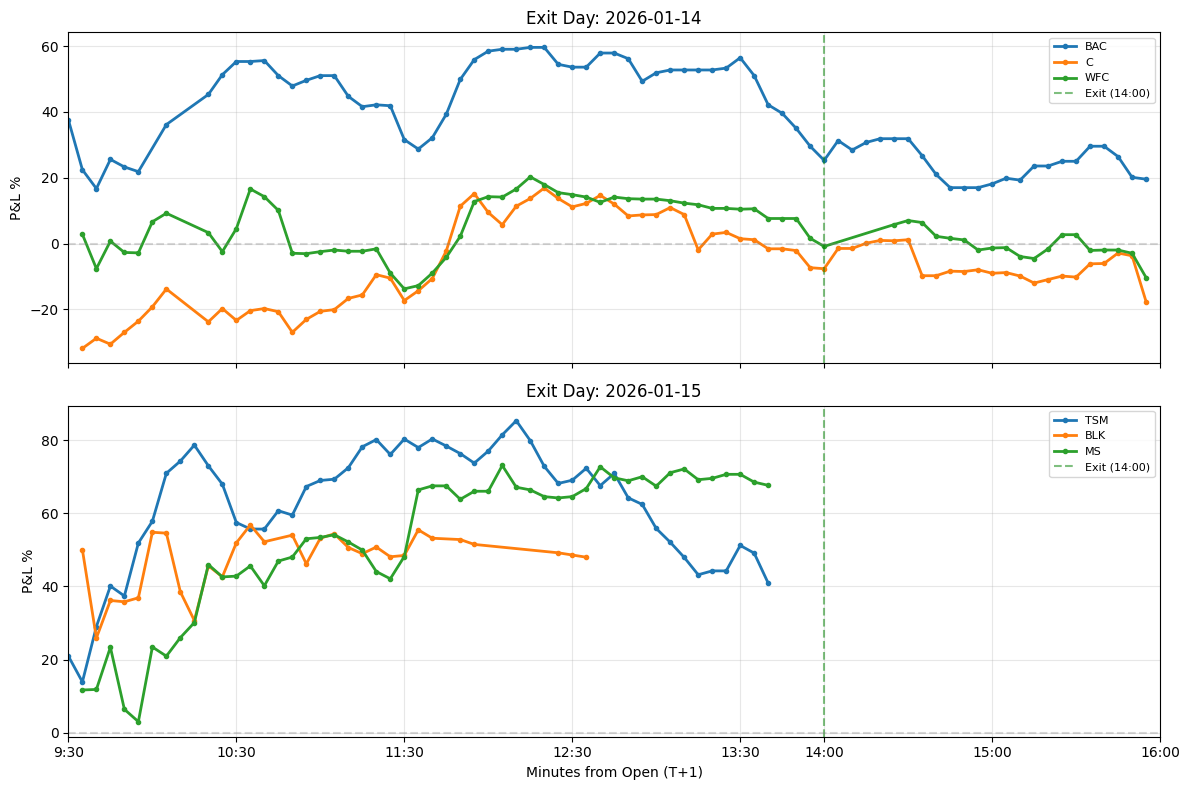

In [49]:
# Subplots by exit day - one row per day, shared x-axis
n_days = len(exit_dates)

if n_days == 0:
    print("No data to plot after filtering.")
else:
    fig, axes = plt.subplots(n_days, 1, figsize=(12, 4*n_days), sharex=True)
    if n_days == 1:
        axes = [axes]  # Make iterable
    
    for i, exit_date in enumerate(exit_dates):
        ax = axes[i]
        day_df = df[df['snap_date'] == exit_date]
        
        for trade_id in day_df['trade_id'].unique():
            trade_df = day_df[day_df['trade_id'] == trade_id]
            ticker = trade_df['ticker'].iloc[0]
            ax.plot(trade_df['exit_day_min'], trade_df['unrealized_pnl_pct'] * 100,
                    marker='o', label=ticker, linewidth=2, markersize=3)
        
        ax.axvline(x=270, color='green', linestyle='--', alpha=0.5, label='Exit (14:00)')
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax.set_ylabel('P&L %')
        ax.set_title(f'Exit Day: {exit_date}')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 390)
    
    axes[-1].set_xlabel('Minutes from Open (T+1)')
    
    # Add time reference to bottom
    time_ticks = [0, 60, 120, 180, 240, 270, 330, 390]
    time_labels = ['9:30', '10:30', '11:30', '12:30', '13:30', '14:00', '15:00', '16:00']
    axes[-1].set_xticks(time_ticks)
    axes[-1].set_xticklabels(time_labels)
    
    plt.tight_layout()
    plt.show()

---
## Summary by Exit Day

In [50]:
# Summary table by exit day
if len(df) > 0:
    # Get the P&L at 14:00 (270 min) for each trade, or latest available
    def get_pnl_at_time(group, target_min=270):
        # Find closest snapshot to target time
        closest_idx = (group['exit_day_min'] - target_min).abs().idxmin()
        return group.loc[closest_idx, 'unrealized_pnl_pct']
    
    day_summary = df.groupby('snap_date').agg({
        'trade_id': 'nunique',
        'unrealized_pnl_pct': 'mean',
        'unrealized_pnl': 'sum'
    }).round(2)
    day_summary.columns = ['Trades', 'Avg P&L %', 'Total P&L $']
    day_summary['Avg P&L %'] = (day_summary['Avg P&L %'] * 100).round(1)
    day_summary['Total P&L $'] = day_summary['Total P&L $'].round(0)
    
    print("Summary by Exit Day (all snapshots):")
    print(day_summary)
else:
    print("No data available.")

Summary by Exit Day (all snapshots):
            Trades  Avg P&L %  Total P&L $
snap_date                                 
2026-01-14       3       13.0      23051.0
2026-01-15       3       55.0     140244.0


---
## All Trades Combined (Overview)

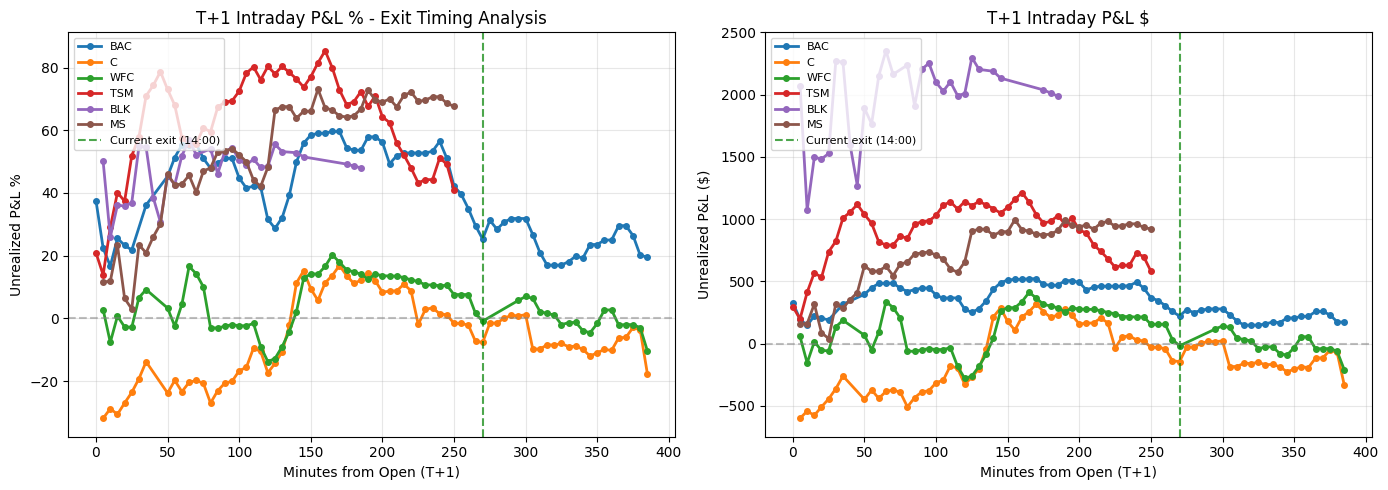

Time reference (minutes from 9:30 ET):
  0 = 9:30, 60 = 10:30, 120 = 11:30, 180 = 12:30
  240 = 13:30, 270 = 14:00 (current exit), 330 = 15:00, 390 = 16:00


In [51]:
# Plot P&L % over time on T+1 (exit day) - all trades on same chart
if len(df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for trade_id in df['trade_id'].unique():
        trade_df = df[df['trade_id'] == trade_id].copy()
        ticker = trade_df['ticker'].iloc[0]
        
        axes[0].plot(trade_df['exit_day_min'], trade_df['unrealized_pnl_pct'] * 100, 
                     marker='o', label=ticker, linewidth=2, markersize=4)
        
        axes[1].plot(trade_df['exit_day_min'], trade_df['unrealized_pnl'], 
                     marker='o', label=ticker, linewidth=2, markersize=4)

    # Mark current exit time (14:00 = 270 min)
    for ax in axes:
        ax.axvline(x=270, color='green', linestyle='--', alpha=0.7, label='Current exit (14:00)')

    axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[0].set_xlabel('Minutes from Open (T+1)')
    axes[0].set_ylabel('Unrealized P&L %')
    axes[0].set_title('T+1 Intraday P&L % - Exit Timing Analysis')
    axes[0].legend(loc='upper left', fontsize=8)
    axes[0].grid(True, alpha=0.3)

    axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Minutes from Open (T+1)')
    axes[1].set_ylabel('Unrealized P&L ($)')
    axes[1].set_title('T+1 Intraday P&L $')
    axes[1].legend(loc='upper left', fontsize=8)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("Time reference (minutes from 9:30 ET):")
    print("  0 = 9:30, 60 = 10:30, 120 = 11:30, 180 = 12:30")
    print("  240 = 13:30, 270 = 14:00 (current exit), 330 = 15:00, 390 = 16:00")

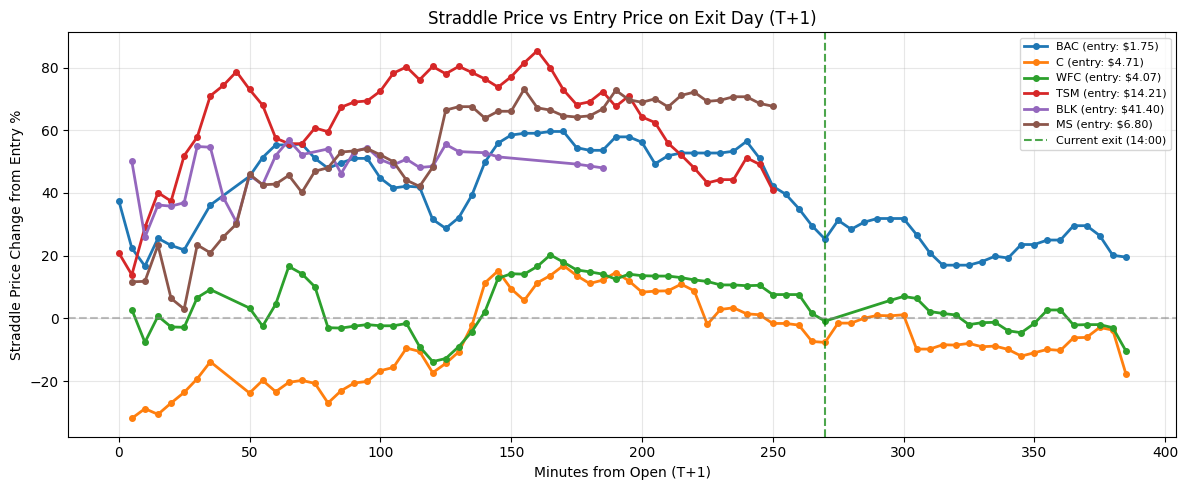

In [52]:
# Straddle mid price over time on T+1 (% change from entry price)
if len(df) > 0:
    fig, ax = plt.subplots(figsize=(12, 5))

    for trade_id in df['trade_id'].unique():
        trade_df = df[df['trade_id'] == trade_id].copy()
        ticker = trade_df['ticker'].iloc[0]
        
        # % change from entry price (what we paid)
        entry_price = trade_df['entry_price_per_contract'].iloc[0]
        pct_change = (trade_df['straddle_mid'] / entry_price - 1) * 100
        
        ax.plot(trade_df['exit_day_min'], pct_change, 
                marker='o', label=f"{ticker} (entry: ${entry_price:.2f})", linewidth=2, markersize=4)

    ax.axvline(x=270, color='green', linestyle='--', alpha=0.7, label='Current exit (14:00)')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Minutes from Open (T+1)')
    ax.set_ylabel('Straddle Price Change from Entry %')
    ax.set_title('Straddle Price vs Entry Price on Exit Day (T+1)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

---
## Exit Timing Analysis

In [53]:
# Summary statistics by time bucket on T+1
if len(df) > 0:
    # Buckets for T+1 exit timing (minutes from 9:30 open)
    df['time_bucket'] = pd.cut(df['exit_day_min'], 
                               bins=[0, 60, 120, 180, 240, 270, 300, 330, 360, 390],
                               labels=['9:30-10:30', '10:30-11:30', '11:30-12:30', '12:30-13:30',
                                       '13:30-14:00', '14:00-14:30', '14:30-15:00', '15:00-15:30', '15:30-16:00'])

    summary = df.groupby('time_bucket', observed=True).agg({
        'unrealized_pnl': ['mean', 'sum'],
        'unrealized_pnl_pct': ['mean', 'std'],
        'trade_id': 'count'
    }).round(2)

    summary.columns = ['Avg P&L $', 'Total P&L $', 'Avg P&L %', 'Std P&L %', 'N Snapshots']
    summary['Avg P&L %'] = (summary['Avg P&L %'] * 100).round(1)
    summary['Std P&L %'] = (summary['Std P&L %'] * 100).round(1)
    print("P&L by Time Bucket on T+1 (Exit Day):")
    print(summary)

    # Also show raw minutes breakdown
    print("\n\nDetailed breakdown by 30-min intervals:")
    df['min_bucket_30'] = (df['exit_day_min'] // 30) * 30
    detail = df.groupby('min_bucket_30').agg({
        'unrealized_pnl_pct': 'mean',
        'trade_id': 'count'
    })
    detail.columns = ['Avg P&L %', 'N']
    detail['Avg P&L %'] = (detail['Avg P&L %'] * 100).round(1)
    print(detail)

P&L by Time Bucket on T+1 (Exit Day):
             Avg P&L $  Total P&L $  Avg P&L %  Std P&L %  N Snapshots
time_bucket                                                           
9:30-10:30      497.52      32339.0       23.0       29.0           65
10:30-11:30     615.82      43723.5       33.0       32.0           71
11:30-12:30     693.31      45758.5       43.0       29.0           66
12:30-13:30     548.23      33442.0       40.0       26.0           61
13:30-14:00     246.11       5414.5       21.0       25.0           22
14:00-14:30     134.86       1888.0       14.0       15.0           14
14:30-15:00       9.86        177.5        4.0       12.0           18
15:00-15:30      -5.06        -91.0        4.0       14.0           18
15:30-16:00       1.10         16.5        5.0       16.0           15


Detailed breakdown by 30-min intervals:
               Avg P&L %   N
min_bucket_30               
0                   13.5  32
30                  32.8  29
60                  31.

In [54]:
# Best/worst times to exit on T+1
if len(df) > 0:
    print("=== T+1 Exit Timing Analysis ===")
    print("(Minutes from market open at 9:30 ET)")

    print("\nBest average P&L % by exit time (30-min buckets):")
    best_times = df.groupby('min_bucket_30')['unrealized_pnl_pct'].mean().sort_values(ascending=False)
    print((best_times * 100).round(1).head(10))

    print("\nTotal P&L $ by exit time (30-min buckets):")
    total_by_time = df.groupby('min_bucket_30')['unrealized_pnl'].sum().sort_values(ascending=False)
    print(total_by_time.round(0).head(10))

    # Time reference
    print("\n=== T+1 Timeline Reference ===")
    print("  0 min   = 9:30 (open)")
    print("  60 min  = 10:30")
    print("  120 min = 11:30")
    print("  180 min = 12:30")
    print("  240 min = 13:30")
    print("  270 min = 14:00 <- CURRENT EXIT TIME")
    print("  330 min = 15:00")
    print("  390 min = 16:00 (close)")

=== T+1 Exit Timing Analysis ===
(Minutes from market open at 9:30 ET)

Best average P&L % by exit time (30-min buckets):
min_bucket_30
150    46.3
180    43.6
210    37.6
120    37.2
90     33.5
30     32.8
60     31.8
240    26.6
0      13.5
270    12.5
Name: unrealized_pnl_pct, dtype: float64

Total P&L $ by exit time (30-min buckets):
min_bucket_30
120    23868.0
90     23262.0
180    21216.0
60     20673.0
150    20511.0
30     19690.0
210    14655.0
0       9588.0
240     7779.0
270     1504.0
Name: unrealized_pnl, dtype: float64

=== T+1 Timeline Reference ===
  0 min   = 9:30 (open)
  60 min  = 10:30
  120 min = 11:30
  180 min = 12:30
  240 min = 13:30
  270 min = 14:00 <- CURRENT EXIT TIME
  330 min = 15:00
  390 min = 16:00 (close)


---
## Total Portfolio P&L by Exit Time

In [ ]:
# Prepare data for total P&L analysis with forward-fill for missing snapshots
if len(df) > 0:
    # Create complete time grid for each trade (0 to max minutes in 5-min increments)
    max_min = int(df['exit_day_min'].max())
    time_grid = list(range(0, max_min + 1, 5))
    
    # For each trade+day combo, forward-fill missing snapshots
    filled_dfs = []
    for (trade_id, snap_date), group in df.groupby(['trade_id', 'snap_date']):
        # Create full time range for this trade
        full_range = pd.DataFrame({'exit_day_min': time_grid})
        full_range['trade_id'] = trade_id
        full_range['snap_date'] = snap_date
        
        # Merge with actual data
        merged = full_range.merge(
            group[['exit_day_min', 'unrealized_pnl', 'unrealized_pnl_pct', 'ticker', 'straddle_mid']],
            on='exit_day_min',
            how='left'
        )
        
        # Forward fill missing values
        merged = merged.ffill()
        
        # Only keep rows after first actual data point
        first_valid = group['exit_day_min'].min()
        merged = merged[merged['exit_day_min'] >= first_valid]
        
        filled_dfs.append(merged)
    
    df_filled = pd.concat(filled_dfs, ignore_index=True)
    print(f"After forward-fill: {len(df_filled)} rows (from {len(df)} original)")
else:
    df_filled = pd.DataFrame()

In [ ]:
# Total Portfolio P&L by Exit Time (All Days Aggregated)
if len(df_filled) > 0:
    # Sum P&L across all trades at each time point
    total_by_time = df_filled.groupby('exit_day_min').agg({
        'unrealized_pnl': 'sum',
        'trade_id': 'nunique'
    }).reset_index()
    total_by_time.columns = ['exit_day_min', 'total_pnl', 'n_trades']
    
    # Find optimal exit time
    best_idx = total_by_time['total_pnl'].idxmax()
    best_time = total_by_time.loc[best_idx, 'exit_day_min']
    best_pnl = total_by_time.loc[best_idx, 'total_pnl']
    
    # P&L at current exit time (14:00 = 270 min)
    pnl_at_270 = total_by_time[total_by_time['exit_day_min'] == 270]['total_pnl'].values
    pnl_at_270 = pnl_at_270[0] if len(pnl_at_270) > 0 else 0
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Fill area under curve
    ax.fill_between(total_by_time['exit_day_min'], 0, total_by_time['total_pnl'],
                    where=(total_by_time['total_pnl'] >= 0), color='green', alpha=0.3)
    ax.fill_between(total_by_time['exit_day_min'], 0, total_by_time['total_pnl'],
                    where=(total_by_time['total_pnl'] < 0), color='red', alpha=0.3)
    
    # Line plot
    ax.plot(total_by_time['exit_day_min'], total_by_time['total_pnl'], 
            linewidth=2, color='blue', label='Total P&L')
    
    # Mark current exit time
    ax.axvline(x=270, color='orange', linestyle='--', linewidth=2, 
               label=f'Current exit (14:00): ${pnl_at_270:,.0f}')
    
    # Mark optimal exit time
    ax.axvline(x=best_time, color='green', linestyle='-', linewidth=2,
               label=f'Best exit ({int(best_time//60)+9}:{int(best_time%60):02d}): ${best_pnl:,.0f}')
    ax.scatter([best_time], [best_pnl], color='green', s=100, zorder=5)
    
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    # Time labels
    time_ticks = [0, 60, 120, 180, 240, 270, 330, 390]
    time_labels = ['9:30', '10:30', '11:30', '12:30', '13:30', '14:00', '15:00', '16:00']
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_labels)
    
    ax.set_xlabel('Exit Time (ET)')
    ax.set_ylabel('Total Portfolio P&L ($)')
    ax.set_title('Total Portfolio P&L by Exit Time (All Days Aggregated)\nForward-filled for missing snapshots')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSummary:")
    print(f"  Best exit time: {int(best_time//60)+9}:{int(best_time%60):02d} ET (${best_pnl:,.0f})")
    print(f"  Current exit (14:00): ${pnl_at_270:,.0f}")
    print(f"  Difference: ${best_pnl - pnl_at_270:+,.0f}")

In [ ]:
# Total Portfolio P&L by Exit Time - Per Day
if len(df_filled) > 0:
    exit_dates = sorted(df_filled['snap_date'].unique())
    n_days = len(exit_dates)
    
    if n_days == 0:
        print("No data to plot.")
    else:
        fig, axes = plt.subplots(n_days, 1, figsize=(14, 4*n_days), sharex=True)
        if n_days == 1:
            axes = [axes]
        
        results = []
        
        for i, exit_date in enumerate(exit_dates):
            ax = axes[i]
            day_df = df_filled[df_filled['snap_date'] == exit_date]
            
            # Sum P&L at each time point for this day
            day_total = day_df.groupby('exit_day_min')['unrealized_pnl'].sum().reset_index()
            day_total.columns = ['exit_day_min', 'total_pnl']
            
            # Find best time for this day
            best_idx = day_total['total_pnl'].idxmax()
            best_time = day_total.loc[best_idx, 'exit_day_min']
            best_pnl = day_total.loc[best_idx, 'total_pnl']
            
            # P&L at 14:00
            pnl_at_270 = day_total[day_total['exit_day_min'] == 270]['total_pnl'].values
            pnl_at_270 = pnl_at_270[0] if len(pnl_at_270) > 0 else 0
            
            results.append({
                'date': exit_date,
                'best_time_min': best_time,
                'best_time_str': f"{int(best_time//60)+9}:{int(best_time%60):02d}",
                'best_pnl': best_pnl,
                'pnl_at_1400': pnl_at_270,
                'diff': best_pnl - pnl_at_270,
                'n_trades': day_df['trade_id'].nunique()
            })
            
            # Fill area
            ax.fill_between(day_total['exit_day_min'], 0, day_total['total_pnl'],
                            where=(day_total['total_pnl'] >= 0), color='green', alpha=0.3)
            ax.fill_between(day_total['exit_day_min'], 0, day_total['total_pnl'],
                            where=(day_total['total_pnl'] < 0), color='red', alpha=0.3)
            
            # Line
            ax.plot(day_total['exit_day_min'], day_total['total_pnl'], 
                    linewidth=2, color='blue')
            
            # Markers
            ax.axvline(x=270, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
            ax.axvline(x=best_time, color='green', linestyle='-', linewidth=1.5, alpha=0.7)
            ax.scatter([best_time], [best_pnl], color='green', s=80, zorder=5)
            ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
            
            # Annotations
            trades_str = ', '.join(day_df['ticker'].unique())
            ax.set_ylabel('Total P&L ($)')
            ax.set_title(f'{exit_date} ({trades_str}) | Best: {int(best_time//60)+9}:{int(best_time%60):02d} (${best_pnl:,.0f}) | 14:00: ${pnl_at_270:,.0f}')
            ax.grid(True, alpha=0.3)
        
        # X-axis labels on bottom plot
        time_ticks = [0, 60, 120, 180, 240, 270, 330, 390]
        time_labels = ['9:30', '10:30', '11:30', '12:30', '13:30', '14:00', '15:00', '16:00']
        axes[-1].set_xticks(time_ticks)
        axes[-1].set_xticklabels(time_labels)
        axes[-1].set_xlabel('Exit Time (ET)')
        
        plt.tight_layout()
        plt.show()
        
        # Summary table
        print("\nPer-Day Summary:")
        results_df = pd.DataFrame(results)
        results_df['diff_str'] = results_df['diff'].apply(lambda x: f"${x:+,.0f}")
        print(results_df[['date', 'n_trades', 'best_time_str', 'best_pnl', 'pnl_at_1400', 'diff_str']].to_string(index=False))

---
## Individual Trade Charts (Small Multiples)

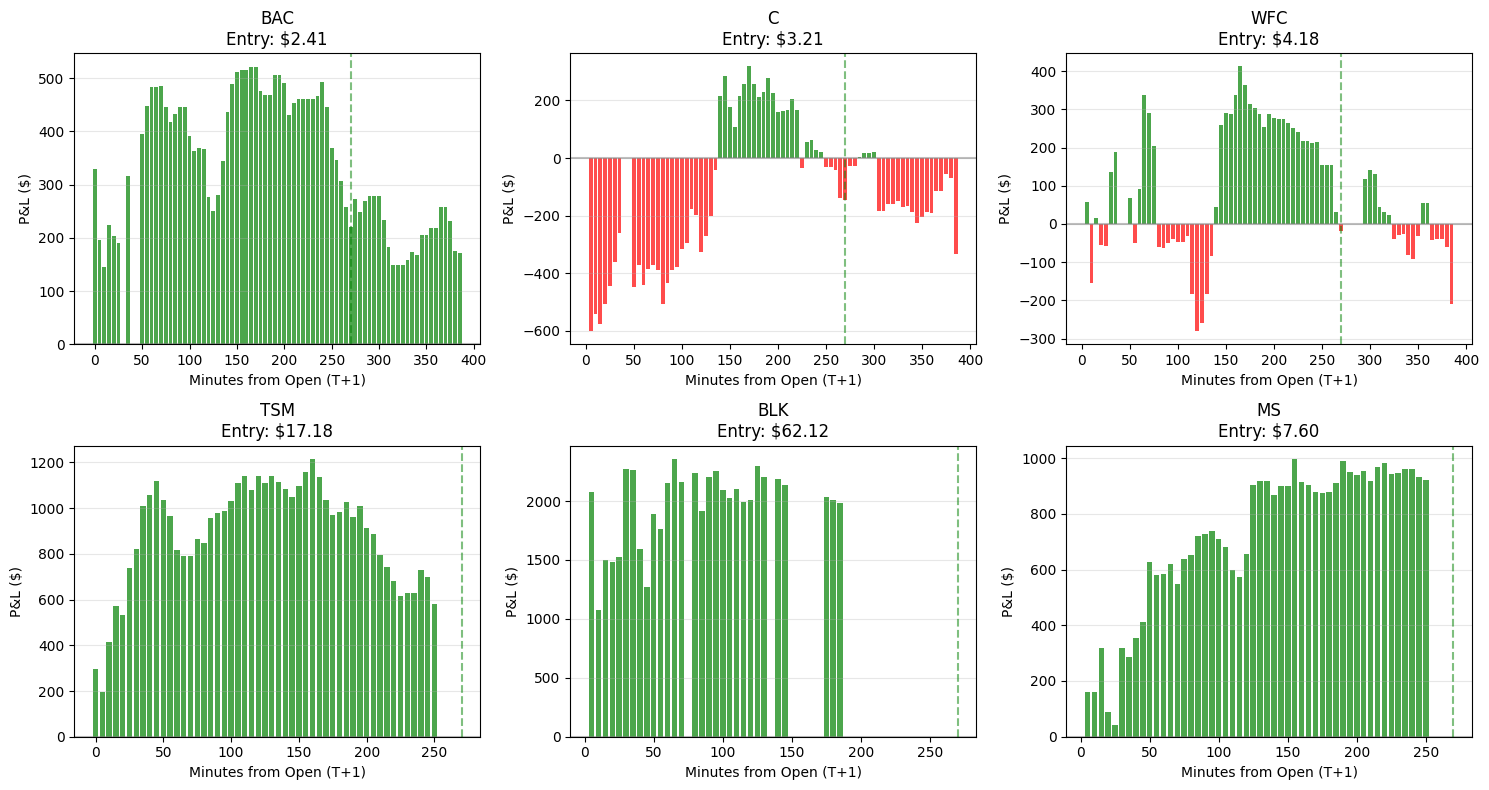

In [55]:
# Individual trade curves on T+1
if len(df) > 0:
    n_trades = df['trade_id'].nunique()
    ncols = min(3, n_trades)
    nrows = (n_trades + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = np.array(axes).flatten() if n_trades > 1 else [axes]

    for i, trade_id in enumerate(df['trade_id'].unique()):
        trade_df = df[df['trade_id'] == trade_id].copy()
        ticker = trade_df['ticker'].iloc[0]
        
        ax = axes[i]
        
        # Plot P&L with color based on value
        colors = ['green' if x >= 0 else 'red' for x in trade_df['unrealized_pnl']]
        ax.bar(trade_df['exit_day_min'], trade_df['unrealized_pnl'], 
               color=colors, alpha=0.7, width=4)
        
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        ax.axvline(x=270, color='green', linestyle='--', alpha=0.5, label='Exit (14:00)')
        ax.set_xlabel('Minutes from Open (T+1)')
        ax.set_ylabel('P&L ($)')
        ax.set_title(f'{ticker}\nEntry: ${trade_df["straddle_mid"].iloc[0]:.2f}')
        ax.grid(True, alpha=0.3, axis='y')

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

---
## What-If Exit Analysis

In [56]:
# Load actual exit data for comparison
conn = sqlite3.connect(DB_PATH)
trades_df = pd.read_sql_query("""
    SELECT trade_id, ticker, premium_paid, exit_pnl, exit_pnl_pct, 
           realized_move_pct, implied_move, exit_datetime
    FROM trades 
    WHERE status = 'exited' AND exit_pnl IS NOT NULL
""", conn)
conn.close()

print(f"Completed trades: {len(trades_df)}")
trades_df

Completed trades: 3


,trade_id,ticker,premium_paid,exit_pnl,exit_pnl_pct,realized_move_pct,implied_move,exit_datetime
0,BAC_2026-01-14_20260113191803,BAC,874.0,176.0,0.201373,0.040756,0.032036,2026-01-14T19:00:04.680271
1,WFC_2026-01-14_20260113191805,WFC,2035.0,-85.0,-0.041769,0.050947,0.042813,2026-01-14T19:00:02.770660
2,C_2026-01-14_20260113191806,C,1884.0,-184.0,-0.097665,0.037752,0.040079,2026-01-14T19:00:00.704299


In [57]:
# Compare: What if we exited at different times on T+1?
if len(df) > 0:
    print("=== T+1 What-If Exit Analysis ===")
    print("(Minutes from 9:30 ET open)")

    for trade_id in df['trade_id'].unique():
        trade_df = df[df['trade_id'] == trade_id].copy()
        ticker = trade_df['ticker'].iloc[0]
        
        # Find actual exit P&L if available
        actual = trades_df[trades_df['trade_id'] == trade_id]
        actual_pnl = actual['exit_pnl'].iloc[0] if len(actual) > 0 else None
        
        best_idx = trade_df['unrealized_pnl'].idxmax()
        worst_idx = trade_df['unrealized_pnl'].idxmin()
        
        # Convert minutes to time
        def min_to_time(m):
            h = int(9 + m // 60)
            mm = int((30 + m) % 60)
            return f"{h:02d}:{mm:02d}"
        
        print(f"\n{ticker}:")
        best_min = trade_df.loc[best_idx, 'exit_day_min']
        worst_min = trade_df.loc[worst_idx, 'exit_day_min']
        last_min = trade_df['exit_day_min'].iloc[-1]
        
        print(f"  Best intraday P&L:  ${trade_df['unrealized_pnl'].max():,.0f} at {min_to_time(best_min)} ({best_min:.0f} min)")
        print(f"  Worst intraday P&L: ${trade_df['unrealized_pnl'].min():,.0f} at {min_to_time(worst_min)} ({worst_min:.0f} min)")
        print(f"  Latest snapshot:    ${trade_df['unrealized_pnl'].iloc[-1]:,.0f} at {min_to_time(last_min)} ({last_min:.0f} min)")
        if actual_pnl is not None:
            print(f"  Actual exit P&L:    ${actual_pnl:,.0f}")

=== T+1 What-If Exit Analysis ===
(Minutes from 9:30 ET open)

BAC:
  Best intraday P&L:  $521 at 11:15 (165 min)
  Worst intraday P&L: $146 at 09:40 (10 min)
  Latest snapshot:    $171 at 15:55 (385 min)
  Actual exit P&L:    $176

C:
  Best intraday P&L:  $318 at 11:20 (170 min)
  Worst intraday P&L: $-600 at 09:35 (5 min)
  Latest snapshot:    $-332 at 15:55 (385 min)
  Actual exit P&L:    $-184

WFC:
  Best intraday P&L:  $412 at 11:15 (165 min)
  Worst intraday P&L: $-280 at 11:30 (120 min)
  Latest snapshot:    $-210 at 15:55 (385 min)
  Actual exit P&L:    $-85

TSM:
  Best intraday P&L:  $1,213 at 11:10 (160 min)
  Worst intraday P&L: $198 at 09:35 (5 min)
  Latest snapshot:    $581 at 13:40 (250 min)

BLK:
  Best intraday P&L:  $2,352 at 10:35 (65 min)
  Worst intraday P&L: $1,073 at 09:40 (10 min)
  Latest snapshot:    $1,988 at 12:35 (185 min)

MS:
  Best intraday P&L:  $995 at 11:05 (155 min)
  Worst intraday P&L: $41 at 09:55 (25 min)
  Latest snapshot:    $921 at 13:40 (2